# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

fontsize = 9
matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": fontsize - 1,
    "axes.titlesize": fontsize - 1,
    "axes.labelsize": fontsize - 2,
    "legend.fontsize": fontsize - 1,
    "legend.frameon": False,
    "lines.linewidth": 1,
})


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ0: Is the experiment sound?

Dataset analysis of CICIDS full and sampled. We chose sampled because of the scale of the experiments, but are the results still valid?

**See `dataset.ipynb` for details.**

PCA analysis on each dataset produced similar projections.
There are massive overlaps between the classes in this projection (showing either that 2 dimensions are not enough to separate the classes, or that there are features that are not relevant to the classification task).

Yet, the projected patterns are identical between the two datasets.
This means that the sampled dataset is representative of the full dataset.

Additionally, computing the PCA's projection from one dataset and applying it to the other produces the same results.
This emphasizes the fact that the two datasets are similar.

## RQ1: Is the behavior predictable?

A preliminary question to solve is how predictable is the behavior of the attack propagation, given a scenario and a distribution; *ie.*, how scattered are the results at a given point in time, for different seeds.

### Test methodology

Test a set of different seeds on: 5/5, continuous-100. Plot:
1. stats
   - mean
   - standard deviation (envelope mean-std, mean+std)
   - min/max
2. differential analysis 
   - |mean-mean^-1| over time
   - |std-std^-1| over time

**Seeds list**: 1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("longruns/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,5-5
epochs,"300_10x30, 300_1x300, 300_4x75"
scenario,continuous-100
target,untargeted
batch_size,"32, 512"
partitioner,iid
seed,"5555, 1138, 501, 2187, 1313, 327, 1977, 421, 3263827, 6567"


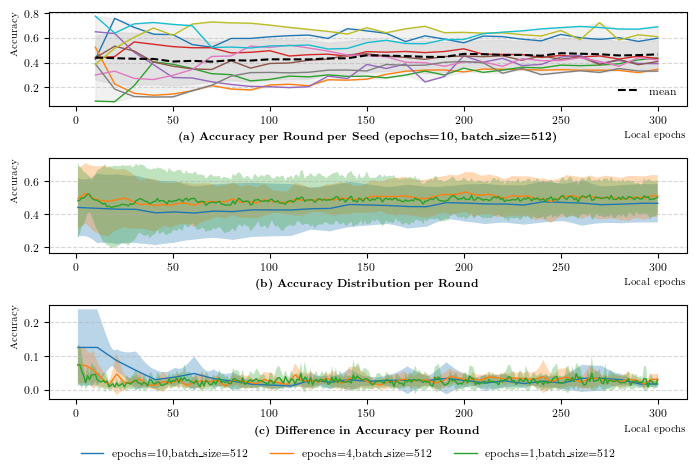

In [4]:
import itertools
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

load_fn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

search_fn = partial(
    search_results,
    "longruns/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)


fig, axs = plt.subplots(3, 1, figsize=figsize(1, 2 / 3, two_column=True), sharex=True)

# Axis 0: Accuracy per Round per Seed
# -------------------------------------
epochs = 10
batch_size = 512
ax: Axes = axs[0]
ax.set_title(
    f"Accuracy per Round per Seed ({epochs=}, {batch_size=})",
)

accs = [
    Plotable(m, load_fn(m))
    for m in search_fn(epochs=f"300_{epochs}x.*", batch_size=batch_size)
]


# stack the values
data = np.array([p.values for p in accs])
mean = np.mean(data, axis=0)
sigma = np.std(data, axis=0)
low_sigma = mean - sigma
high_sigma = mean + sigma
_min = np.min(data, axis=0)
_max = np.max(data, axis=0)

# plot
x = np.arange(
    1 * int(epochs), len(mean) * int(epochs) + 1, int(epochs)
)  # rounds are indexed from 1 and occur every 10 epochs

for acc in accs:
    ax.plot(x, acc.values)

ax.plot(
    x,
    mean,
    label="mean",
    linewidth=1.5,
    color="black",
    linestyle="--",
)
ax.fill_between(x, low_sigma, high_sigma, alpha=0.5, color="lightgrey")
ax.fill_between(x, _min, _max, alpha=0.3, color="lightgrey")
ax.legend(loc="lower right")

# Axis 1: Accuracy Distribution per Round
# -------------------------------------
ax: Axes = axs[1]
ax.set_title("Accuracy Distribution per Round")

color_counter = 0
for epochs, batch_size in itertools.product([10, 4, 1], [512]):
    accs = scale(
        [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
        ],
        300,
    )

    # stack the values
    data = np.array([p.values for p in accs])

    # Compute mean & standard deviation
    mean = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    low_sigma = mean - sigma
    high_sigma = mean + sigma

    # plot
    x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

    ax.plot(
        x,
        mean,
        label=f"{epochs=},{batch_size=}",
        linewidth=1,
        color=f"C{color_counter}",
    )
    ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
    color_counter += 1

# Axis 2: Difference in Accuracy per Round
# -------------------------------------
ax: Axes = axs[2]
ax.set_title("Difference in Accuracy per Round")

color_counter = 0
for epochs, batch_size in itertools.product([10, 4, 1], [512]):
    accs = [
        Plotable(m, load_fn(m))
        for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
    ]

    accs_diff = scale(
        [
            Plotable(
                p.name,
                [abs(p.values[1] - p.values[0])]
                + [abs(p.values[i] - p.values[i - 1]) for i in range(1, len(p.values))],
            )
            for p in accs
        ],
        300,
    )

    # stack the values
    data = np.array([p.values for p in accs_diff])

    # Compute mean & standard deviation
    mean = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    low_sigma = mean - sigma
    high_sigma = mean + sigma

    # plot
    x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

    ax.plot(
        x,
        mean,
        label=f"{epochs=},{batch_size=}",
        linewidth=1,
        color=f"C{color_counter}",
    )
    ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
    color_counter += 1

abc = "abcdefghijklmnopqrstuvwxyz"
for ax in axs:
    letter = abc[axs.tolist().index(ax)]
    ax.tick_params(labelbottom=True)
    ax.set_xlabel("Local epochs", loc="right")
    ax.set_ylabel("Accuracy", loc="top")
    ax.set_title(r"\textbf{" f"({letter}) {ax.get_title()}" r"}", y=-0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3)
fig.tight_layout()
fig.subplots_adjust(bottom=0.14)
fig.savefig(SAVEDIR + "predictability.pdf")

There is a surprisingly high amount of dispersion in the results between runs. 
With a simple example (batch size 512, 1 local epoch per round, 50% of attackers), the accuracy varies from ~0.1 to ~0.8 for the **same** round (after 10 rounds).
Standard deviation is around 0.2, which is a lot considering the scale (between 0 and 1).

Longer runs (300 local epochs, batch size 512) show a stabilization in the results, but the dispersion is still high.
Notably, after round 10, there are no more evolution (on average) in each run, so each run is stable after 10 rounds.

It could be interpreted as a consequence of the complexity of the learning tasks, which becomes harder as clients contain different labels for similar samples.
Therefore, the problem probably admit a high number of local minima, which are reached depending on the seed.

Finally, the accuracy difference never really reaches zero, so while the models do converge, they continue to vary slightly.

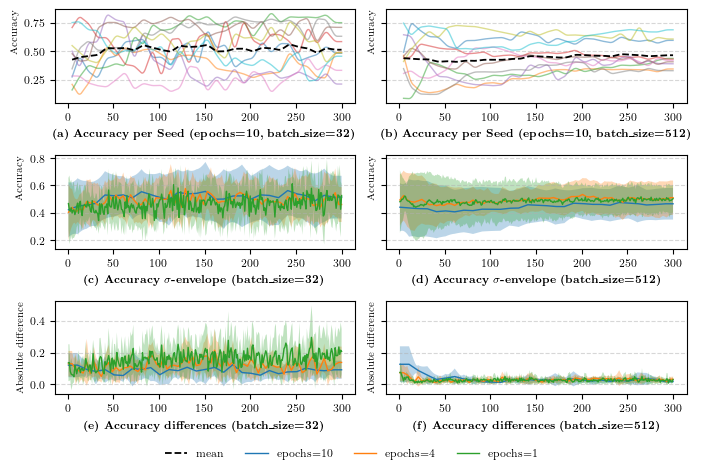

In [5]:
import functools
from functools import partial

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt

load_fn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

search_fn = partial(
    search_results,
    "longruns/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)


fig, axs = plt.subplots(
    3, 2, figsize=figsize(1, 2 / 3, two_column=True), sharex=True, sharey="row"
)

# Axis 0: Accuracy per Seed
# -------------------------------------
for ax, batch_size in zip(axs[0, :], [32, 512]):
    ax: Axes
    epochs = 10
    ax.set_title(
        f"Accuracy per Seed ({epochs=}, {batch_size=})",
    )
    ax.set_ylabel("Accuracy", loc="top")

    accs = scale(
        [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=f"300_{epochs}x.*", batch_size=batch_size)
        ],
        300,
    )

    # stack the values
    data = np.array([p.values for p in accs])
    x = np.arange(1, len(data[0]) + 1)  # rounds are indexed from 1

    mean = pd.DataFrame(np.mean(data, axis=0), index=x)
    mean = mean.rolling(window=5).mean()
    sigma = pd.DataFrame(np.std(data, axis=0))
    low_sigma = mean - sigma
    high_sigma = mean + sigma
    _min = np.min(data, axis=0)
    _max = np.max(data, axis=0)

    # plot

    for acc in accs:
        ax.plot(pd.DataFrame(acc.values, index=x).rolling(window=5).mean(), alpha=0.5)

    ax.plot(
        mean,
        label="mean",
        linewidth=1.3,
        color="black",
        linestyle="--",
    )
    # ax.fill_between(x, low_sigma, high_sigma, alpha=0.5, color="lightgrey")
    # ax.fill_between(x, _min, _max, alpha=0.3, color="lightgrey")

# Axis 1: Accuracy Distribution
# -------------------------------------
for ax, batch_size in zip(axs[1, :], [32, 512]):
    ax: Axes
    ax.set_title(rf"Accuracy $\sigma$-envelope ({batch_size=})")
    ax.set_ylabel("Accuracy", loc="top")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = scale(
            [
                Plotable(m, load_fn(m))
                for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=f"{epochs=}",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
        color_counter += 1

# Axis 2: Difference in Accuracy
# -------------------------------------
for ax, batch_size in zip(axs[2, :], [32, 512]):
    ax: Axes
    ax.set_title(f"Accuracy differences ({batch_size=})")
    ax.set_ylabel("Absolute difference", loc="top")

    color_counter = 0
    for epochs in [10, 4, 1]:
        accs = [
            Plotable(m, load_fn(m))
            for m in search_fn(epochs=rf"300_{epochs}x.*", batch_size=batch_size)
        ]

        accs_diff = scale(
            [
                Plotable(
                    p.name,
                    [abs(p.values[1] - p.values[0])]
                    + [
                        abs(p.values[i] - p.values[i - 1])
                        for i in range(1, len(p.values))
                    ],
                )
                for p in accs
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs_diff])

        # Compute mean & standard deviation
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        # plot
        x = np.arange(1, len(mean) + 1)  # rounds are indexed from 1

        ax.plot(
            x,
            mean,
            label=f"{epochs=}",
            linewidth=1,
            color=f"C{color_counter}",
        )
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.3)
        color_counter += 1

abc = "abcdefghijklmnopqrstuvwxyz"
for ax in axs.flatten():
    letter = abc[axs.flatten().tolist().index(ax)]
    ax.tick_params(labelbottom=True)
    ax.set_title(r"\textbf{%s}" % f"({letter}) {ax.get_title()}", y=-0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

handles, labels = functools.reduce(
    lambda x, y: (x[0] + y[0], x[1] + y[1]),
    map(lambda ax: ax.get_legend_handles_labels(), [axs[0, 0], axs[2, 1]]),
)
fig.legend(handles, labels, loc="lower center", ncol=4)
fig.tight_layout()
fig.subplots_adjust(bottom=0.15)
fig.savefig(SAVEDIR + "predictability-all.pdf")

With less local epochs or a smaller batch size, the dispersion is even higher, and the models appear to be less stable.
Notably, the accuracy difference grows over time for the second run (epochs=10, batch_size=32).
This is to factor in for subsequent analyses using this combination, as it can affect the observed results.

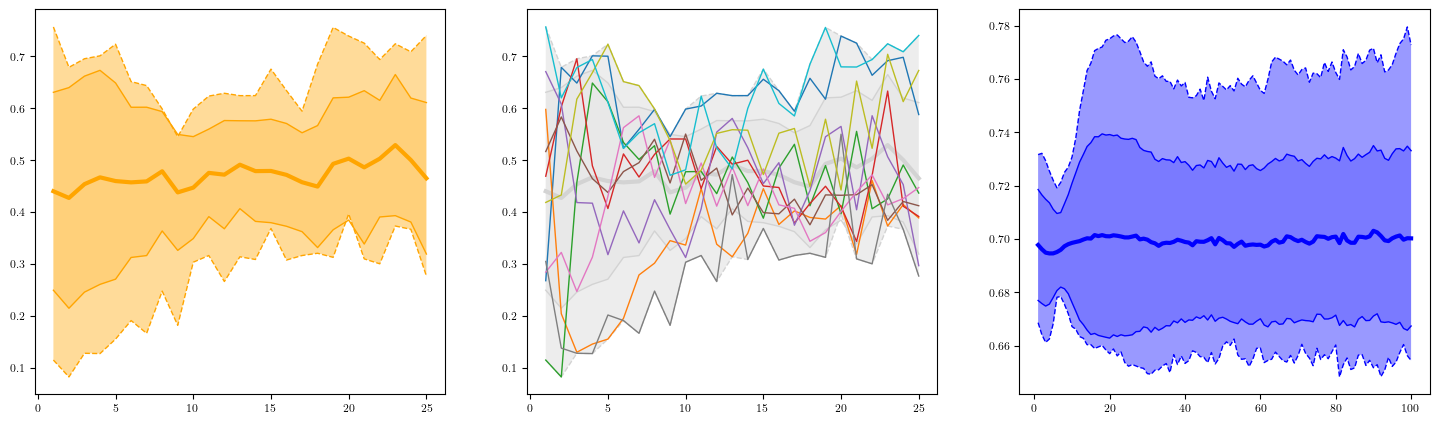

In [6]:
import re
from functools import partial

from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, envelope
from matplotlib import pyplot as plt

fn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

plotables_acc = [
    Plotable(m, fn(m))
    for m in search_results(
        "hyperparams/results/",
        scenario="continuous-100",
        target="untargeted",
        batch_size="128",
        distribution="5-5",
        epochs=".*4x.*",
        datasets=".*cicids",
    )
]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

envelope(plotables_acc, axs[0])
envelope(plotables_acc, axs[1], color="lightgrey")

for plotable in plotables_acc:
    match = re.search(r"seed=(\d+)", plotable.name)
    if match is None:
        raise ValueError(f"Could not find seed in {plotable.name}")
    axs[1].plot(
        range(1, len(plotable.values) + 1),
        plotable.values,
        label=f"seed={match.group(1)}",
    )


fn = partial(
    load_metric, attr="distributed", dotpath="global.loss", with_malicious=False
)
plotables_loss = [
    Plotable(m, fn(m))
    for m in search_results(
        "hyperparams/results/",
        scenario="continuous-100",
        target="untargeted",
        batch_size="512",
        distribution="5-5",
        epochs=".*1x.*",
        datasets=".*cicids",
    )
]

envelope(plotables_loss, axs[2], color="blue")

The loss seems quite close at the beginning, but diverges quickly, especially the max.
Local models probably fit their data at first, but because of the high amount of attackers, the participants cannot converge to a representative global model, which leads to high variance in the results.

### Conclusions

- A 100% continuous attack perpetrated by 50% of the nodes produces **in average** a 50% detection rate.
- Over ten runs, the results are very sparse: the standard deviation is very high, and the min/max values are very far from the mean.

If the mean value does not change, and neither does the distribution of the results, then it pretty much acts like if the rounds where independent. 
So maybe the ML operations are consequent enough (even for one epoch) that it neglects the impact of the initial conditions on the output.

The results *tend* to confirm the expected hypotheses **in average**. However, it is difficult to predict the behavior of one specific attack.
The results of further analyses (RQ1-4) must be interpreted with this in mind.

**THEREFORE**: While the results of existing defense mechanisms are not to be discarded, such unpredictability might mean that some specific attacks might bypass them if they are not designed to be robust to such variations.



## RQ2: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?


### Test methodology
- look at all variations of hyperparameters: `["batch_size", "epochs"]`; learning rate does not need to be tested as Adam (optimizer) has an adaptive learning rate.
	- all curves on one plot
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
	- scenario `continuous-100`
- distribution `10-0` and `5-5`
- do it twice for untargeted vs targeted
- do the same for `late-3` to see the impact of previous training

In [7]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("hyperparams/results/"))

Key,Values
distribution,"5-5, 10-0"
epochs,"100_10x10, 100_4x25, 100_1x100"
scenario,continuous-100
target,untargeted
batch_size,"128, 512, 32"
datasets,nfv2_sampled_cicids
partitioner,iid
seed,"1313, 1977, 327, 5555, 501, 421, 3263827, 2187, 1138, 6567"


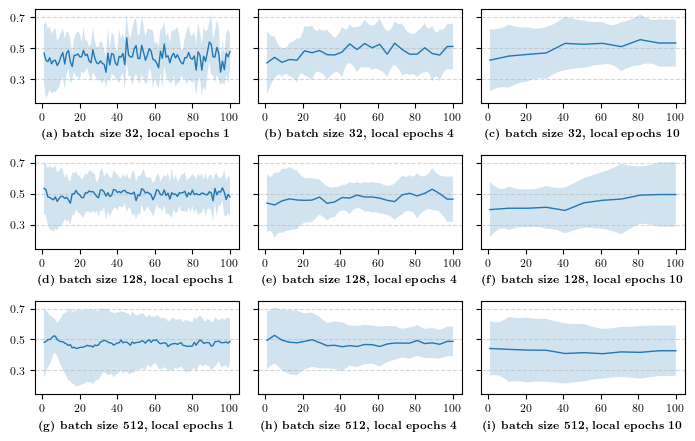

In [8]:
from functools import partial

from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig, axs = plt.subplots(
    3,
    3,
    figsize=figsize(1, 2 / 3, two_column=True),
    sharey=True,
)

for ax, (batch_size, epochs) in zip(
    axs.ravel(), itertools.product([32, 128, 512], [1, 4, 10])
):
    ax: Axes
    ax.set_title(f"batch size {batch_size}, local epochs {epochs}")

    plotables_attack = scale(
        [
            Plotable(m, loadfn(m))
            for m in searchfn(
                batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution="5-5"
            )
        ],
        100,
    )

    data = np.array([p.values for p in plotables_attack])
    mean = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    low_sigma = mean - sigma
    high_sigma = mean + sigma

    x = np.arange(1, len(mean) + 1)
    ax.plot(x, mean, label=f"{batch_size=},{epochs=}")
    ax.fill_between(x, low_sigma, high_sigma, alpha=0.2)

abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs.ravel()):
    letter = abc[i]
    ax.tick_params(labelbottom=True)
    ax.set_yticks([0.3, 0.5, 0.7])
    # ax.set_yticklabels([.3 .5, .7])
    ax.set_title(r"\textbf{%s}" % f"({letter}) {ax.get_title()}", y=-0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

handles, labels = functools.reduce(
    lambda x, y: (x[0] + y[0], x[1] + y[1]),
    map(lambda ax: ax.get_legend_handles_labels(), [axs[0, 0], axs[2, 1]]),
)

fig.tight_layout()
fig.subplots_adjust(bottom=0.15)
fig.savefig(SAVEDIR + "hyperparams-continuous-attack-9grid.pdf")

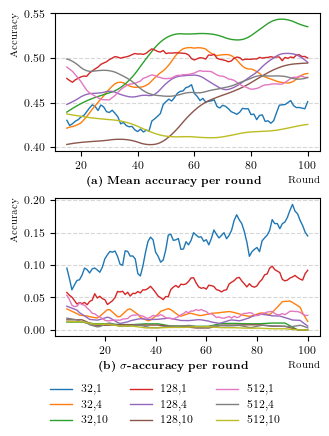

In [9]:
from functools import partial

import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig, axs = plt.subplots(
    2,
    1,
    figsize=figsize(1, 1.3),
)

ax1, ax2 = axs

for i, (batch_size, epochs) in enumerate(itertools.product([32, 128, 512], [1, 4, 10])):
    plotables_attack = scale(
        [
            Plotable(m, loadfn(m))
            for m in searchfn(
                batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution="5-5"
            )
        ],
        100,
    )

    data = np.array([p.values for p in plotables_attack])
    x = np.arange(1, data.shape[1] + 1)
    mean = pd.DataFrame(np.mean(data, axis=0), x)
    smean = mean.rolling(window=15).mean()

    diffs = np.abs(data[:, 1:] - data[:, :-1])
    # duplicate the first column to keep the same shape
    diffs = np.concatenate([diffs[:, :1], diffs], axis=1)
    mean_diff = pd.DataFrame(np.mean(diffs, axis=0), x)
    smean_diff = mean_diff.rolling(window=5).mean()

    x = np.arange(1, len(mean) + 1)
    ax1.plot(x, smean, label=f"{batch_size},{epochs}", color=f"C{i}")
    ax2.plot(x, smean_diff, label=f"{batch_size},{epochs}", color=f"C{i}")

ax1.set_title("Mean accuracy per round")
ax2.set_title(r"$\sigma$-accuracy per round")
abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs):
    ax.set_title(r"\textbf{%s}" % f"({abc[i]}) {ax.get_title()}", y=-0.3, x=0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Round", loc="right")
    ax.set_ylabel("Accuracy", loc="top")


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower center")
fig.tight_layout()
fig.subplots_adjust(bottom=0.22)
# fig.savefig(SAVEDIR + "hyperparams-continuous-attack-curves.pdf")

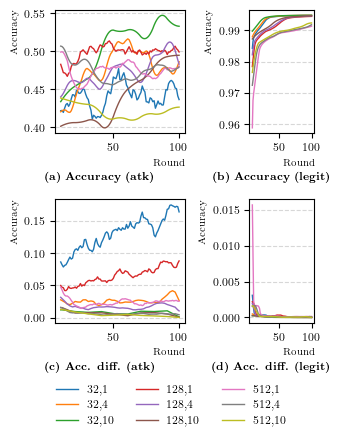

In [37]:
from functools import partial

import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig, axs = plt.subplots(
    2, 2, figsize=figsize(1, 1.3), gridspec_kw={"width_ratios": [2, 1]}
)

for (ax_mean, ax_diff), dist in zip(axs.T, ["5-5", "10-0"]):
    for i, (batch_size, epochs) in enumerate(
        itertools.product([32, 128, 512], [1, 4, 10])
    ):
        plotables_attack = scale(
            [
                Plotable(m, loadfn(m))
                for m in searchfn(
                    batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution=dist
                )
            ],
            100,
        )

        data = np.array([p.values for p in plotables_attack])
        x = np.arange(1, data.shape[1] + 1)
        mean = pd.DataFrame(np.mean(data, axis=0), x)
        smean = mean.rolling(window=10).mean()

        diffs = np.abs(data[:, 1:] - data[:, :-1])
        # duplicate the first column to keep the same shape
        diffs = np.concatenate([diffs[:, :1], diffs], axis=1)
        mean_diff = pd.DataFrame(np.mean(diffs, axis=0), x)
        smean_diff = mean_diff.rolling(window=10).mean()

        x = np.arange(1, len(mean) + 1)
        ax_mean.plot(x, smean, label=f"{batch_size},{epochs}", color=f"C{i}")
        ax_diff.plot(x, smean_diff, label=f"{batch_size},{epochs}", color=f"C{i}")

    ax_mean.set_title(f"Accuracy ({'atk' if dist == '5-5' else 'legit'})")
    ax_diff.set_title(f"Acc. diff. ({'atk' if dist == '5-5' else 'legit'})")


abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs.ravel()):
    ax.set_title(
        r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}", y=-0.44, x=0.35, wrap=True
    )
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Round", loc="right")
    ax.set_ylabel("Accuracy", loc="top")

handles, labels = ax_mean.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower center")
fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig(SAVEDIR + "hyperparams-continuous-curves.pdf")

There seem to be no significant differences between the hyperparameter selections in terms of performance under constant attacks behavior.
However, we can clearly see that difference in terms of dispersion between the two scenarios (10-0 and 5-5). There are almost no dispersion in the 10-0 scenario, meaning that all runs converge to approximately the same result.

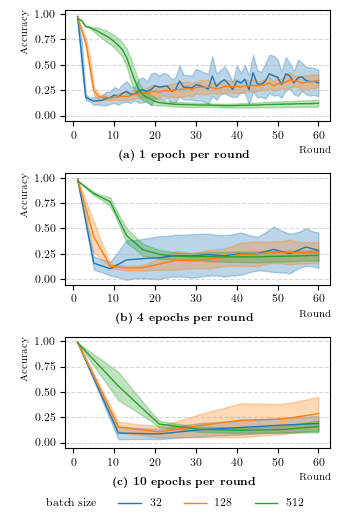

In [34]:
from functools import partial

from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "late/results/",
    scenario="late-3",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

fig, axs = plt.subplots(
    3,
    1,
    figsize=figsize(1, 3 / 2),
    sharey=True,
)

for ax, epochs in zip(axs, [1, 4, 10]):
    ax: Axes
    ax.set_title(f"{epochs} epoch{'s' if epochs > 1 else ''} per round")

    for i, batch_size in enumerate([32, 128, 512]):
        plotables_attack = scale(
            [
                Plotable(m, loadfn(m))
                for m in searchfn(batch_size=batch_size, epochs=rf".*{epochs}x.*")
            ],
            100,
        )

        data = np.array([p.values for p in plotables_attack])
        data = data[:, epochs : epochs + 60]  # start one round before the attack
        x = np.arange(1, data.shape[1] + 1)
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        ax.plot(x, mean, label=f"{batch_size}", color=f"C{i}")
        ax.fill_between(x, low_sigma, high_sigma, alpha=0.3, color=f"C{i}")

abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs.ravel()):
    ax.set_title(r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}", y=-0.4, x=0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Round", loc="right")
    ax.set_ylabel("Accuracy", loc="top")

handles, labels = axs[0].get_legend_handles_labels()
handles.insert(0, plt.plot([], [], linestyle="")[0])  # fake handle
labels.insert(0, "batch size")
leg = fig.legend(
    handles, labels, ncol=4, loc="lower center", bbox_to_anchor=(0.45, -0.04)
)

fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.savefig(SAVEDIR + "hyperparams-late.pdf")

We align the curves so that they all start at the last known value before the attack starts, and measure the impact over 60 epochs (*i.e.*, 6, 24 or 60 rounds).

We observe a steeper drop in performance for smaller batches, while all other conditions are the same. 
Further, bigger batch sizes seem to have less variance.

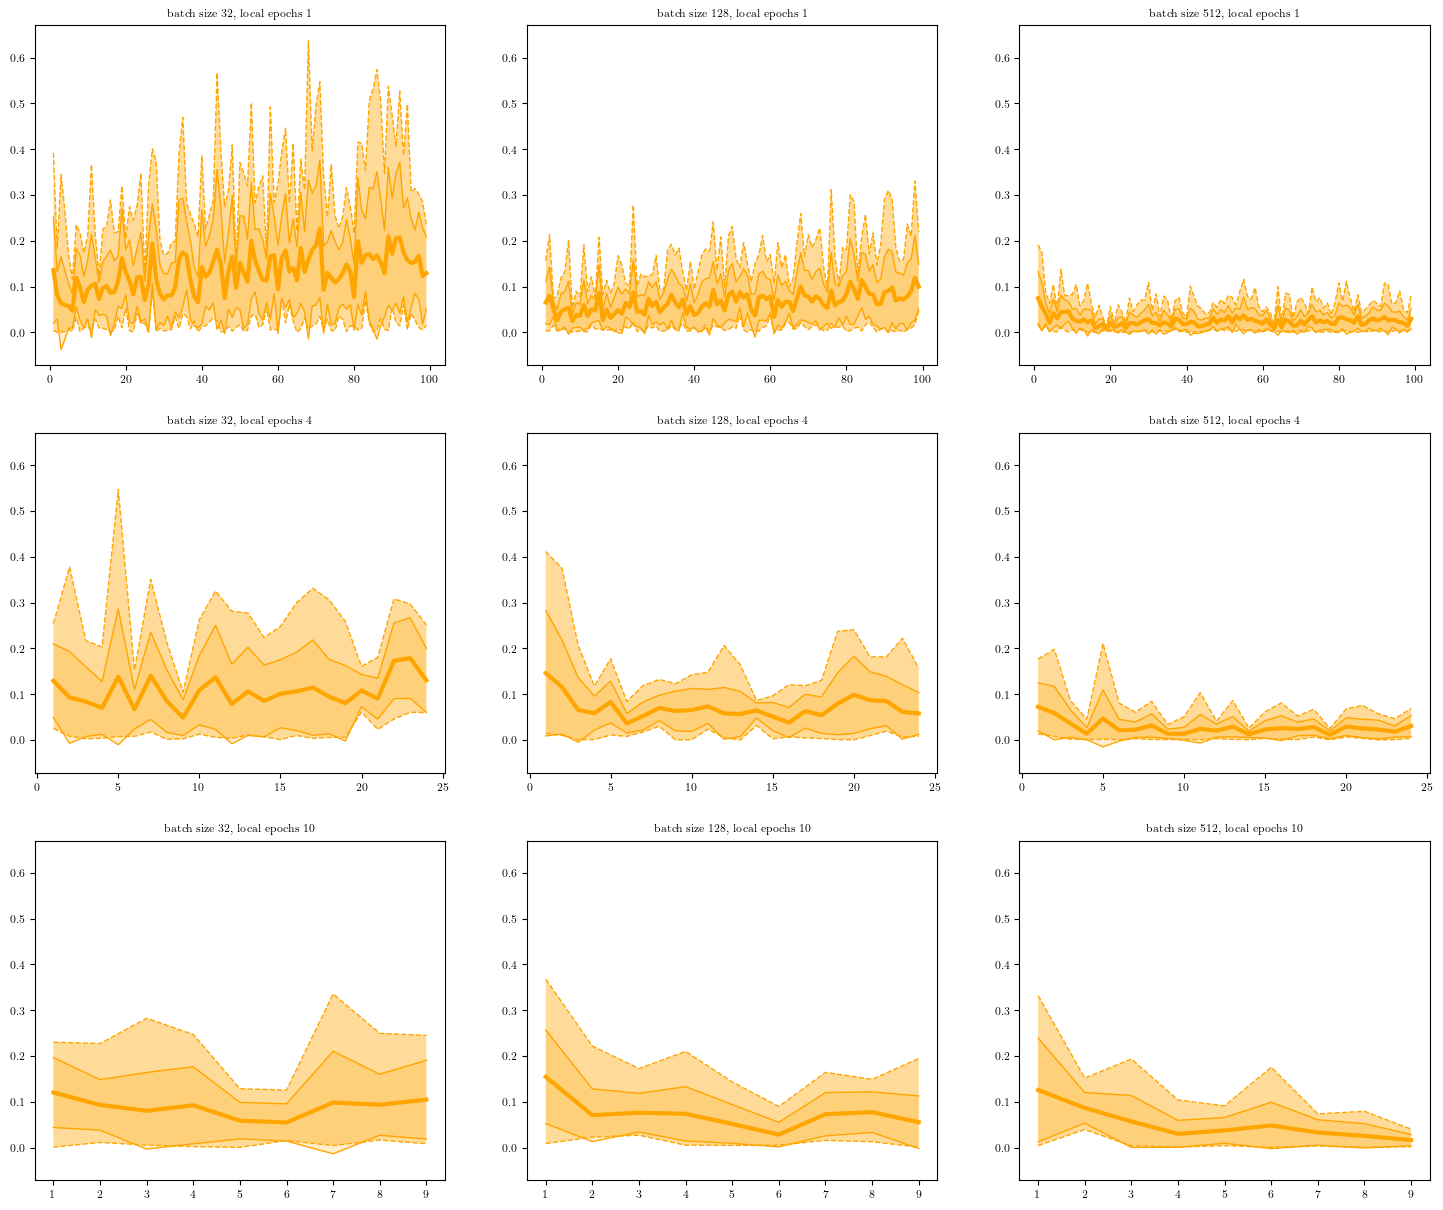

In [12]:
from functools import partial

from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, envelope

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)


def diff(plotable: Plotable) -> Plotable:
    return Plotable(
        plotable.name,
        [
            abs(plotable.values[i] - plotable.values[i - 1])
            for i in range(1, len(plotable.values))
        ],
    )


fig, axs = plt.subplots(3, 3, figsize=(18, 15), sharey=True)

for i, batch_size in enumerate(["32", "128", "512"]):
    for j, epochs in enumerate(["1", "4", "10"]):
        axs[j, i].set_title(f"batch size {batch_size}, local epochs {epochs}")
        axs[j, i].yaxis.set_tick_params(labelleft=True)

        plotables = [
            Plotable(m, loadfn(m))
            for m in searchfn(batch_size=batch_size, epochs=rf".*{epochs}x.*")
        ]
        plotables = [diff(p) for p in plotables]  # differencial analysis
        envelope(plotables, axs[j, i])

Over time, the evolution in mean over time gets smaller, which means that the model tends to converge to a stable state.
Overall, the bigger the batch size and the number of local epochs, the more predictable the behavior is.
This is quite expected in terms of stability, and seems in phase with results from the literature.

### Conclusions

1. Some hyperparameters have an impact on the performance of the model poisoning, but it is not significant enough to be used as a defense mechanism. In average, the performance is the same.
2. A smaller batch size leads to a steeper drop in performance when poisoning starts. Therefore, in performance-constrained use cases (such as (I)IoT), the defense mechanisms need to react quicker to mitigate the impact of the attack. Round-based defense mechanisms (that apply the defense at the end of each round) might not be very affected, but reputation-based defenses (that account for the last interactions) might be impacted.
   Note: This is not a problem for Trust-FIDS, which targets CIDS in CSFL environments, and therefore is not performance-constrained.
3. The more local epochs per round, and the bigger the batch size, better the convergence of the model is. With a batch size of 512 and 10 local epochs, the models' variations diminish over time, leading to a more stable model. Note that this does not mean that the model is better, but that it is more stable. This is a good thing for the defense mechanisms, as it means that the attack is more predictable, and therefore easier to defend against.

## RQ3: At what point do poisoning attacks start having an impact?
- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
- for each `["continuous-10","continuous-30","continuous-60","continuous-100"]` 
	- display all distributions on one plot (`["10-0","9-1","7-3","5-5","3-7"]`)

### Untargeted attacks

In [13]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("attacks-untargeted/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"10-0, 9-1, 3-7, 7-3, 5-5"
epochs,100_10x10
scenario,"continuous-60, continuous-90, continuous-100, continuous-10, continuous-30, continuous-80, continuous-99, continuous-70, continuous-95"
target,untargeted
batch_size,512
partitioner,iid
seed,"1977, 1138, 6567, 327, 2187, 501, 3263827, 1313, 421, 5555"


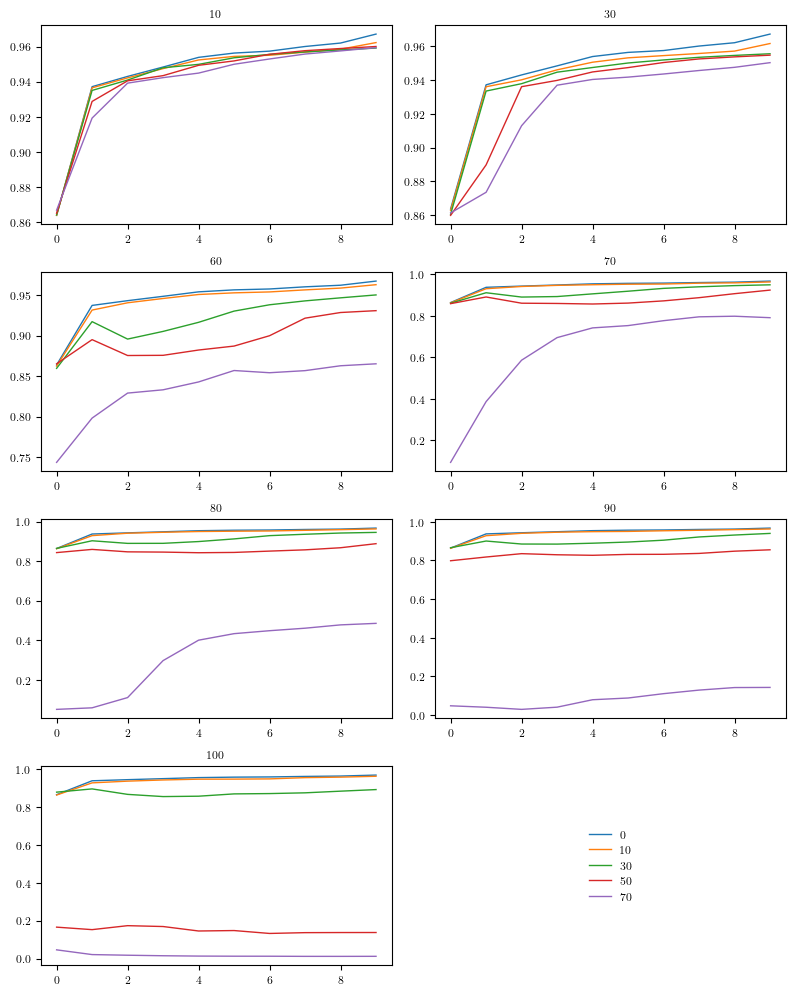

In [14]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable

searchfn = partial(
    search_results, "attacks-untargeted/results/", target="untargeted", epochs=".*10x.*"
)

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.f1", with_malicious=False
)

fig, axs = plt.subplots(4, 2, figsize=(8, 10))

for i, scenario in enumerate([
    "continuous-10",
    "continuous-30",
    "continuous-60",
    "continuous-70",
    "continuous-80",
    "continuous-90",
    "continuous-100",
]):
    axs[i // 2, i % 2].set_title(f"{scenario.split('-')[-1]}% of poisoned data")
    axs[i // 2, i % 2].yaxis.set_tick_params(labelleft=True)

    for dist in ["10-0", "9-1", "7-3", "5-5", "3-7"]:
        plotables = [
            Plotable(m, loadfn(m))
            for m in searchfn(scenario=scenario, distribution=dist)
        ]
        data = np.column_stack([p.values for p in plotables])
        axs[i // 2, i % 2].plot(
            data.mean(axis=1), label=f"{int(dist.split('-')[-1])*10}% malicious"
        )

axs[-1, -1].axis("off")
lines, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, -1].legend(lines, labels, loc="center")
fig.tight_layout()

There is a massive difference between 60% and 100% of poisoned data.
At 60%, even with 50% of attackers, the performance is still very high (>=0.85).
Starting at 80%, we start to see a significant drop in performance, and at >=90%, the performance is very low (<=0.2).
Only with 100% of poisoned data, we see a significant drop in performance with 50% of attackers.

Further, below 80% of poisoned data, and while the participants take time to converge, most participants achieve relatively high results (F1-score).

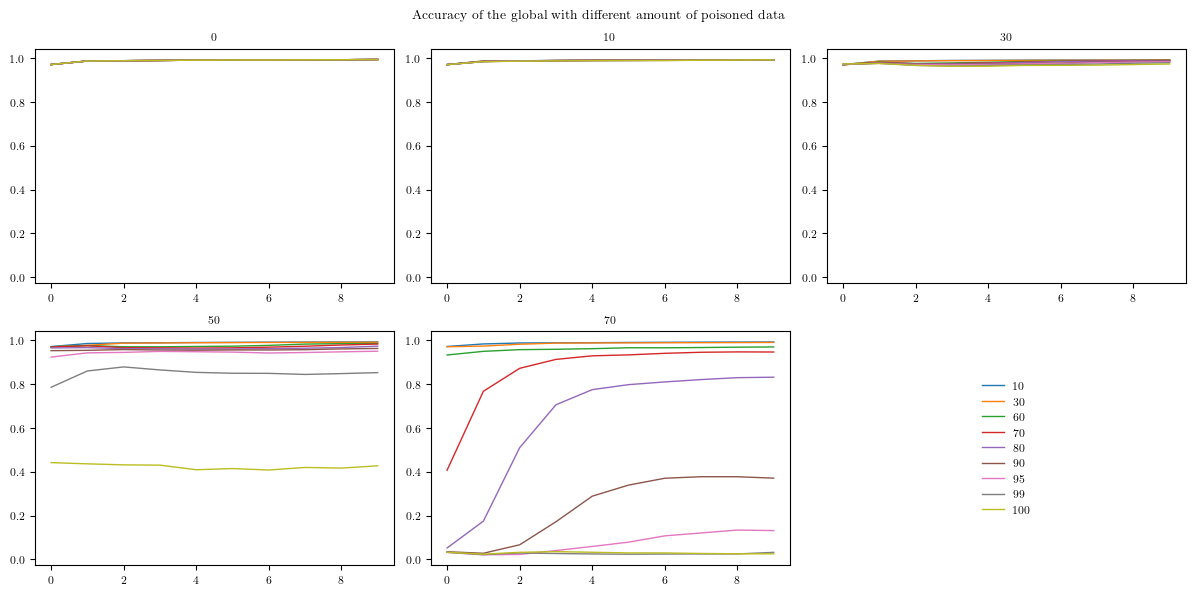

In [15]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable

searchfn = partial(
    search_results, "attacks-untargeted/results/", target="untargeted", epochs=".*10x.*"
)

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True)

for i, dist in enumerate(["10-0", "9-1", "7-3", "5-5", "3-7"]):
    axs[i // 3, i % 3].set_title(f"{int(dist.split('-')[-1])*10}% malicious")
    axs[i // 3, i % 3].yaxis.set_tick_params(labelleft=True)

    for scenario in [
        "continuous-10",
        "continuous-30",
        "continuous-60",
        "continuous-70",
        "continuous-80",
        "continuous-90",
        "continuous-95",
        "continuous-99",
        "continuous-100",
    ]:
        plotables = [
            Plotable(m, loadfn(m))
            for m in searchfn(scenario=scenario, distribution=dist)
        ]
        data = np.column_stack([p.values for p in plotables])
        axs[i // 3, i % 3].plot(
            data.mean(axis=1), label=f"{scenario.split('-')[-1]}% of poisoned data"
        )

axs[-1, -1].axis("off")
lines, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, -1].legend(lines, labels, loc="center")
fig.suptitle("Accuracy of the global with different amount of poisoned data")
fig.tight_layout()

Plotted the other way around, we see how non-linear the relation between the proportion of poisoned data and the performance is.
At 50% of malicious clients, there is a massive threshold effect between 99% and 100% of poisoned data.

Another interesting aspects is that even with 30% of attackers, and despite keeping high performance, the poisoning impact is still not linear.
The biggest gap is between 99% and 100% of poisoned data, while there almost no difference 70% and 80%.

### Targeted attacks

In [38]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("attacks-targeted/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"7-3, 3-7, 9-1"
epochs,100_10x10
scenario,"continuous-90, continuous-80, continuous-99, continuous-10, continuous-70, continuous-95"
target,"ddos, dos, bot, infiltration, bruteforce"
batch_size,512
partitioner,iid
seed,"5555, 3263827, 1138, 6567, 1313, 2187, 327, 421, 1977, 501"


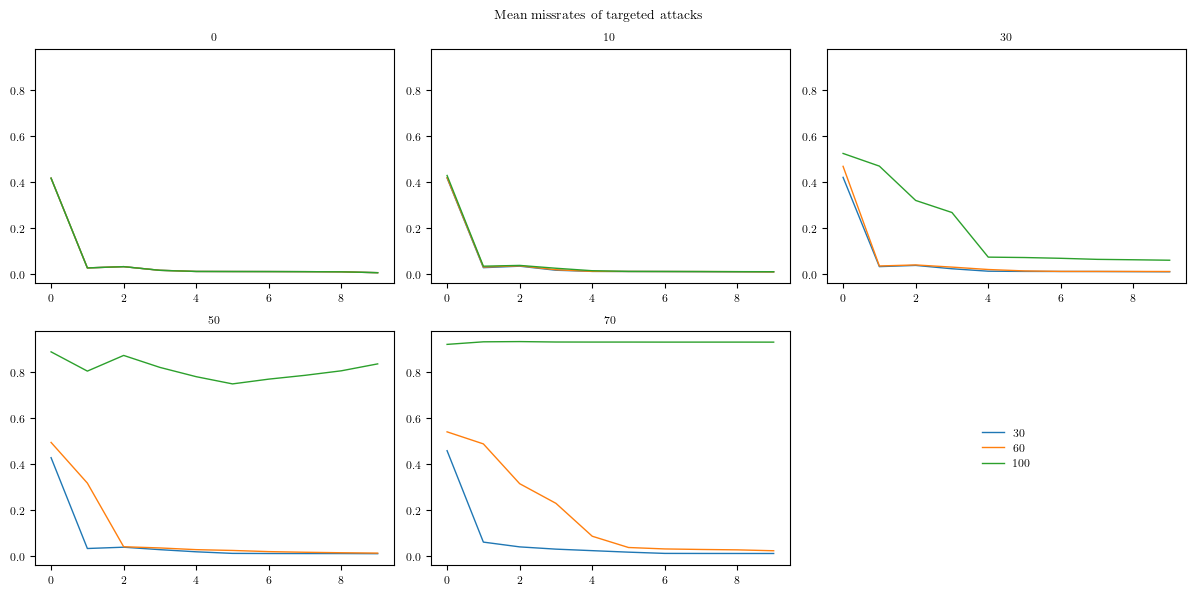

In [16]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_metric, search_results

labels = {
    "Bot": "bot",
    "DDoS": "ddos",
    "DoS": "dos",
    "Brute Force": "bruteforce",
    # We exclude these attacks from the analysis because there detection is too difficult
    # "Infilteration": "infiltration",
    # "injection": "injection",
}

searchfn = partial(search_results, "backdoor/results/", epochs=".*10x.*")


fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True)

for i, dist in enumerate(["10-0", "9-1", "7-3", "5-5", "3-7"]):
    axs[i // 3, i % 3].set_title(f"{int(dist.split('-')[-1])*10}% malicious")
    axs[i // 3, i % 3].yaxis.set_tick_params(labelleft=True)

    for scenario in [
        "continuous-30",
        "continuous-60",
        "continuous-100",
    ]:
        data = []

        for label in labels:
            loadfn = partial(
                load_metric,
                attr="distributed",
                dotpath=f"{label}.missrate",
                with_malicious=False,
            )
            values = [
                loadfn(m)
                for m in searchfn(
                    scenario=scenario, distribution=dist, target=labels[label]
                )
            ]
            data.append(np.column_stack([p for p in values]))

        concat_data = np.concatenate(data, axis=1)

        axs[i // 3, i % 3].plot(
            concat_data.mean(axis=1),
            label=f"{scenario.split('-')[-1]}% of poisoned data",
        )

axs[-1, -1].axis("off")
lines, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, -1].legend(lines, labels, loc="center")
fig.suptitle("Mean missrates of targeted attacks")
fig.tight_layout()

Similarly, for targeted attacks, it takes a majority of participants to really influence the model.

Yet, at 50% of attackers, the targeted classes accuse an average missrate >= 0.8, which is quite high.
Thus, fewer attackers are needed to influence the model, which can be a critical aspect in a real-world scenario.


## RQ4: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- focus on scenario `redemption-3`
	- all distributions: `["10-0","9-1","7-3","5-5","3-7"]`
	- targeted vs untargeted
	- one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)

In [17]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("redemption/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"7-3, 3-7, 5-5, 10-0, 9-1"
epochs,"100_10x10, 100_4x25"
scenario,redemption-3
target,"dos, untargeted"
batch_size,512
partitioner,iid
seed,"1313, 1977, 3263827, 6567, 327, 421, 5555, 501, 2187, 1138"


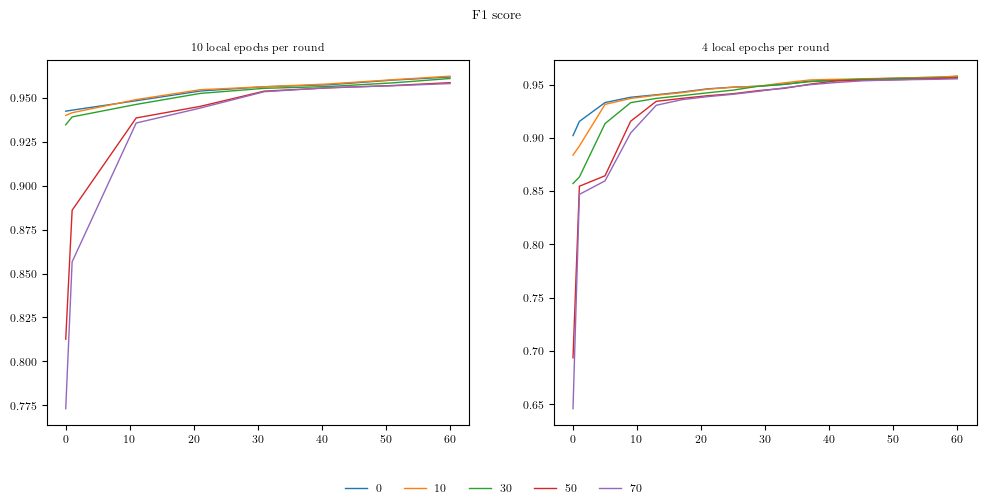

In [18]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import scale

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("F1 score")
axs[0].set_title("10 local epochs per round")
axs[1].set_title("4 local epochs per round")

searchfn_10 = partial(
    search_results,
    "redemption/results/",
    target="untargeted",
    epochs=".*10x.*",
    scenario="redemption-3",
)

searchfn_4 = partial(
    search_results,
    "redemption/results/",
    target="untargeted",
    epochs=".*4x.*",
    scenario="redemption-3",
)

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.f1", with_malicious=False
)

for i, dist in enumerate(["10-0", "9-1", "7-3", "5-5", "3-7"]):
    plotables_10 = scale(
        [Plotable(m, loadfn(m)) for m in searchfn_10(distribution=dist)], 100
    )
    plotables_10 = [p[2 * 10 - 1 : 2 * 10 + 60] for p in plotables_10]
    x = np.arange(2 * 10, 2 * 10 + 60)
    data_10 = np.column_stack([p.values for p in plotables_10])
    axs[0].plot(data_10.mean(axis=1), label=f"{int(dist.split('-')[-1])*10}% malicious")

    plotables_4 = scale(
        [Plotable(m, loadfn(m)) for m in searchfn_4(distribution=dist)], 100
    )

    plotables_4 = [p[2 * 4 - 1 : 2 * 4 + 60] for p in plotables_4]
    data_4 = np.column_stack([p.values for p in plotables_4])
    axs[1].plot(data_4.mean(axis=1), label=f"{int(dist.split('-')[-1])*10}% malicious")


# Shrink current axis's height by 10% on the bottom
for ax in axs:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.05, box.width, box.height * 0.95])
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5)

The model recovers very quickly from the poisoning attack, even with 70% of attackers. 
This is true even for lower epochs numbers.
The impact of the distribution is not significant, as the model still recovers very quickly.

<span style="color:red">
<b>TODO</b>: It is currently unclear whether smaller batch sizes would have an impact on the recovery time, as it has one on the poisoning time.
Should we test that?
Intuitively, it should not have an impact, as all participants converge very quickly without attackers.
</span>

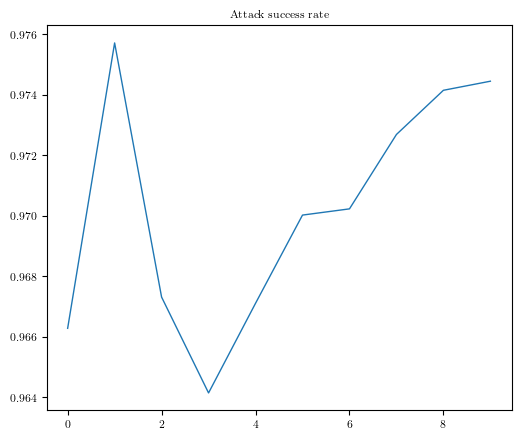

In [19]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_asr, search_results

searchfn = partial(
    search_results,
    "attacks-untargeted/results/",
    target="untargeted",
    scenario="continuous-100",
)

ref = np.array([load_asr(m) for m in searchfn(distribution="10-0")])
ref = ref.mean(axis=0).tolist()

rasrs = [load_asr(m, reference=ref) for m in searchfn(distribution="3-7")]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title("Attack success rate")
ax.plot(np.array(rasrs).mean(axis=0), label="attack success rate")

## RQ5: Are backdoor attacks realistic in IDS context?

Note that this does not refer to the backdoor attacks as often defined in ML, but more as backdoors applied to NIDS, where the attacker makes it so that the IDS does not detect a specific attack or attack pattern.

## Test methodology

- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
- focus on targeted attacks (test all targets)
- look especially at the attack success rate (see def in Trust-FIDS)

**Note**: some results must be gathered from other runs (*eg.*, class "dos" has been removed here since it's already available in "attacks/").

In [20]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("backdoor/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"3-7, 7-3, 10-0, 5-5, 9-1"
epochs,100_10x10
scenario,"continuous-60, continuous-100, continuous-30"
target,"ddos, dos, bot, bruteforce, injection, infiltration"
batch_size,512
partitioner,iid
seed,"6567, 421, 2187, 327, 1313, 1977, 3263827, 5555, 501, 1138"


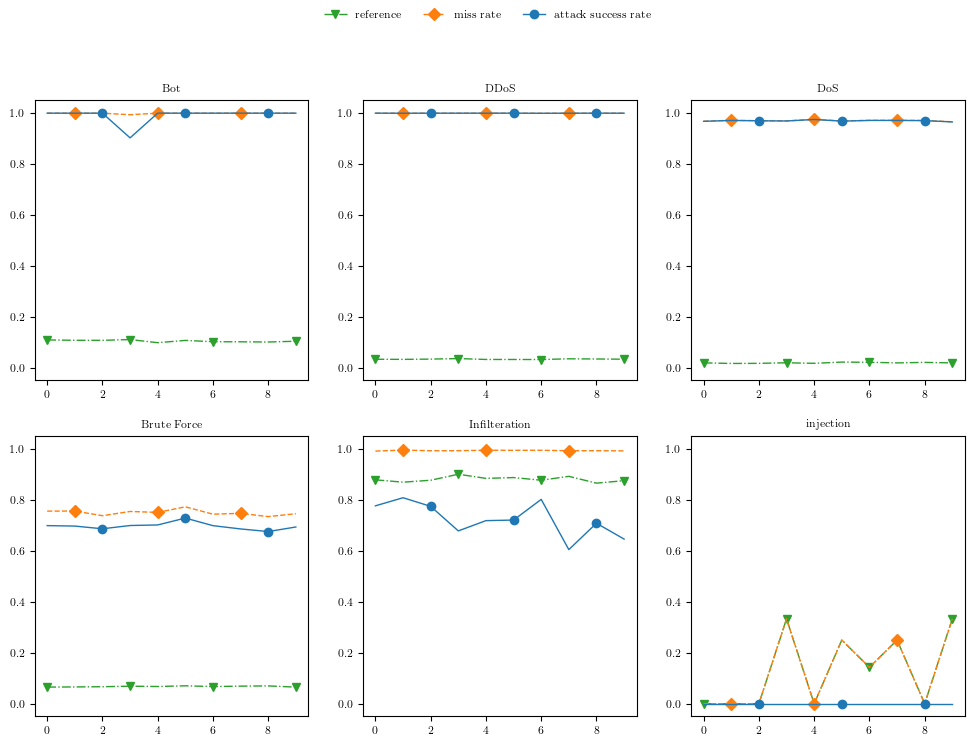

In [21]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_asr, load_metric, search_results
from eiffel.analysis.plot import COLORS, LINESTYLES, MARKERS
from matplotlib.axes import Axes

labels = {
    "Bot": "bot",
    "DDoS": "ddos",
    "DoS": "dos",
    "Brute Force": "bruteforce",
    "Infilteration": "infiltration",
    "injection": "injection",
}

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

asr_style = {
    "color": next(COLORS),
    "marker": next(MARKERS),
    "linestyle": next(LINESTYLES),
}
missrate_style = {
    "color": next(COLORS),
    "marker": next(MARKERS),
    "linestyle": next(LINESTYLES),
}
ref_style = {
    "color": next(COLORS),
    "marker": next(MARKERS),
    "linestyle": next(LINESTYLES),
}

for i, label in enumerate(labels):
    ax: Axes = axs[i // 3, i % 3]

    searchfn = partial(
        search_results,
        "backdoor/results/",
        target=labels[label],
        scenario="continuous-100",
    )
    missfn = partial(
        load_metric,
        attr="distributed",
        dotpath=f"{label}.missrate",
        with_malicious=False,
    )
    asrfn = partial(load_asr, target=[label])

    refs = [asrfn(m) for m in searchfn(distribution="10-0")]
    ax.plot(
        np.mean(np.array(refs), axis=1),
        label="reference",
        markevery=(0, 3),
        **ref_style,  # type: ignore
    )

    paths = [m for m in searchfn(distribution="3-7")]
    missrate = [missfn(p) for p in paths]
    ax.plot(
        np.mean(np.array(missrate), axis=1),
        label="miss rate",
        markevery=(1, 3),
        **missrate_style,  # type: ignore
    )
    asrs = [asrfn(p, reference=r) for p, r in zip(paths, refs)]
    ax.plot(
        np.mean(np.array(asrs), axis=1),
        label="attack success rate",
        markevery=(2, 3),
        **asr_style,  # type: ignore
    )

    ax.set_title(label)
    ax.yaxis.set_tick_params(labelleft=True)

fig.legend(
    *axs[0, 0].get_legend_handles_labels(),
    loc="upper center",
    ncol=3,
)

## RQ6: Is model similarity enough to detect poisoning attacks? (OPTIONAL)

Optionally, the assessment paper can be used to highlight how poisoning can be used to highlight how model distance is not enough to express poisoning whereas cross evaluation can:
- setup two IID clients from the same dataset
- drop classes so that similarity is low
- keep one common attack class that is partially poisoned by one
- show the results of the aggregation (impact on perf), with the similarity and eval score